In [1]:
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import tables
from tqdm import tqdm
import os
from random import shuffle
from IPython.display import clear_output
from sklearn import metrics
import time
%matplotlib inline

import os
USE_GPU = True
#os.environ['CUDA_VISIBLE_DEVICES'] = '1' if USE_GPU else ''
EPS = 1e-15

In [2]:
# for phase 1 set num_classes=2
# for phase 2 set num_classes=4
num_classes = 2

In [3]:
train_file = '../../../anaderi-s/train_1-2.hdf5'
test_file = '../../../anaderi-s/test_1-2.hdf5'
submission_file = 'submission_simplified_1-2.hdf5'

In [4]:
%load_ext autoreload
%autoreload 2

# Prepare data

In [5]:
import sys
sys.path.append('../../')

from tools.base import plot_3d, hdf5_to_numpy
from tools.tools import stretch_array

In [6]:
%%time
# N -- number of enties to read. Either int or np.inf. In latter case all entries are readed.
N = 100
X, Y, M, N = hdf5_to_numpy(file=train_file, n=N, num_classes=num_classes)

  0%|          | 0/100 [00:00<?, ?it/s]

6000


100%|██████████| 100/100 [00:41<00:00,  2.41it/s]

CPU times: user 40.1 s, sys: 1.45 s, total: 41.5 s
Wall time: 41.6 s


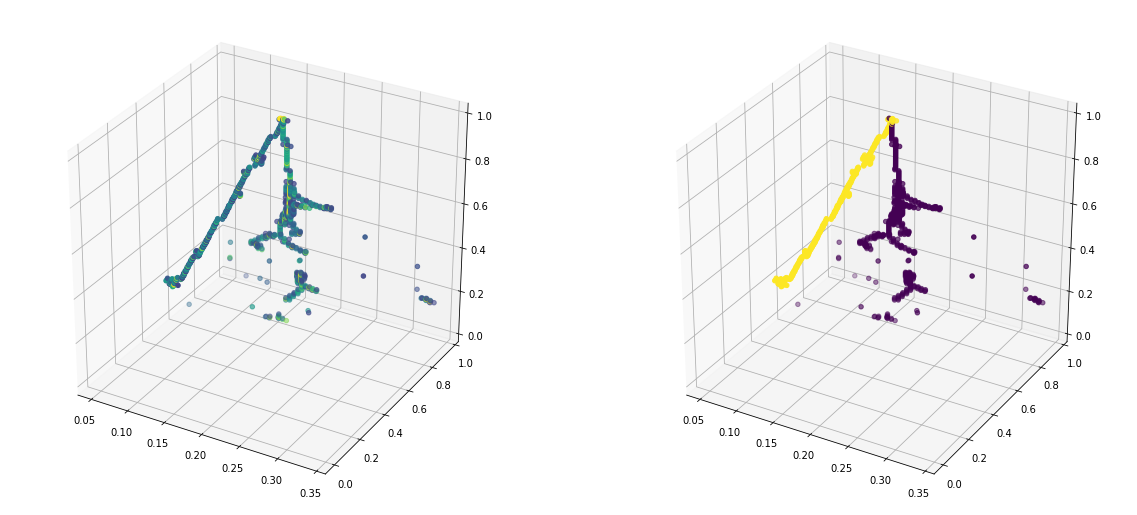

In [7]:
k = -1
plot_3d(X[k], Y[k])

## Creation of graph dataset


![title](img/knn_graph.png)

To compute graph on which we are going to do inference we will use K-nearest neighbours graph. This algorithm draws edges from node(which is, in our case, a hit in the detector) to K closest points.

Tunable parameter:

__n_neighbors__ -- number of neighbours for k-nearest neighbours graph algo(http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.kneighbors_graph.html).

### Ideas

  * try to play with default params;
  * explore different ideas for graph computation: heuristics, radius neighbors graph, etc.;
  * different metrics: manhattan, l1, cosine, metric learning(__hot!__), etc.;

In [8]:
n_neighbors = 20

in_degree_max, out_degree_max = 0, 0

In [9]:
from tools.simplified_clustering import generate_graph_dataset

In [10]:
X_clusters_graph = []
for k in tqdm(range(len(X))):
    if len(X[k]) == 0:
        continue
    # construction of graph based on aggregated statistics
    X_cluster_graph, in_degree_max_local, out_degree_max_local = generate_graph_dataset(X=X[k], Y=Y[k], M=M[k],
                                                                                        n_neighbors=n_neighbors)
    in_degree_max = max(in_degree_max_local, in_degree_max)
    out_degree_max = max(out_degree_max_local, out_degree_max)
    
    X_clusters_graph.append(X_cluster_graph)

100%|██████████| 100/100 [00:04<00:00, 24.38it/s]


### What is __in_degree_max__ and __out_degree_max__?

Well, when you are working with tensorflow you have to specify shape of your data(at least number of columns).

```
shape = (number_of_nodes, out_degree/in_degree)
```

__max_out_degree__ is fixed and equal __n_neighbors__ in our setting, but __in_degree_max__ could be different across different events. 

To anticipate it we are padding all events with edges to non-existing node. Latter this should be taken into account in the MPNN-algorithm.

In [11]:
in_degree_max, out_degree_max

(46, 20)

In [12]:
# padding
for X_cluster_graph in X_clusters_graph:
    X_cluster_graph['X_cluster_messages_out'] = stretch_array(X_cluster_graph['X_cluster_messages_out'], 
                                                              n=out_degree_max, 
                                                              fill_value=len(X_cluster_graph['X_cluster_edges']))
    
    X_cluster_graph['X_cluster_messages_in'] = stretch_array(X_cluster_graph['X_cluster_messages_in'], 
                                                              n=in_degree_max, 
                                                              fill_value=len(X_cluster_graph['X_cluster_edges']))

# Deep learning model (MPNN)




In [13]:
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, GRUCell, GRU
from keras.optimizers import RMSprop
from keras import backend as K
import keras
import tensorflow as tf
from keras.layers import Dropout
from keras.models import Sequential
from keras.activations import relu

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

Using TensorFlow backend.


### Placeholders

In [14]:
X_cluster_graph['X_cluster_nodes'].shape, X_cluster_graph['X_cluster_edges'].shape

((848, 1), (16960, 5))

__X_nodes__ -- features per hit(i.e. energy).

__X_edges__ -- features for each edge that connects two hits(i.e. relative difference of coordinates).

__X_labels__ -- labels ;)

In [15]:
ndim_features_nodes = 4
ndim_features_edges = 5
ndim_message = 6

X_nodes = K.placeholder(shape=(None, ndim_features_nodes), name="nodes") # features of nodes
X_edges = K.placeholder(shape=(None, ndim_features_edges), name="edges") # features of edges
X_labels = K.placeholder(shape=(None, num_classes), name="labels") # labels

__X_nodes_in_out__ -- edge list.

__X_messages_in__ -- in-adjacency lists.

__X_messages_out__ -- out-adjacency lists.

All these graph representations are equivalent. 

In [16]:
X_nodes_in_out = K.placeholder(shape=(None, 2), dtype=np.int32, name="nodes_in_out") # edges
X_messages_in = K.placeholder(shape=(None, in_degree_max), dtype=np.int32, name="messages_in") # shape = (none, size of neighbourhood)
X_messages_out = K.placeholder(shape=(None, out_degree_max), dtype=np.int32, name="messages_out") # shape = (none, size of neighbourhood)

# fake messages to(or from) non-existing node
fake_message_const = K.constant(value=[ndim_message * [-np.inf]]) 

In [17]:
placeholders = {
    'X_nodes': X_nodes,
    'X_edges': X_edges,
    'X_labels': X_labels,
    'X_nodes_in_out': X_nodes_in_out,
    'X_messages_in': X_messages_in,
    'X_messages_out': X_messages_out
}

### NNs

In [18]:
steps = 3

message_passers = {
    0: Sequential(layers=[
                      Dense(16, input_shape=(2 * ndim_features_nodes + ndim_features_edges,), activation=relu), 
                      Dropout(rate=0.05),
                      Dense(ndim_message, activation=relu),
                      Dropout(rate=0.05),
                  ], name="message_passer1"
                 ),
    1: Sequential(layers=[
                      Dense(16, input_shape=(2 * ndim_features_nodes + ndim_features_edges,), activation=relu), 
                      Dropout(rate=0.05),
                      Dense(ndim_message, activation=relu),
                      Dropout(rate=0.05),
                  ], name="message_passer2"
                 ),    
    2: Sequential(layers=[
                      Dense(16, input_shape=(2 * ndim_features_nodes + ndim_features_edges,), activation=relu), 
                      Dropout(rate=0.05),
                      Dense(ndim_message, activation=relu),
                      Dropout(rate=0.05),
                  ], name="message_passer3"
                 )
}

In [19]:
#state_updater = tf.contrib.rnn.GRUCell(num_units=ndim_features_nodes, )
state_updater = Sequential(layers=[
                      Dense(16, input_shape=(2 * ndim_message + ndim_features_nodes,), activation=relu), 
                      Dense(ndim_features_nodes),
                                  ], name="state_updater"
                          )

In [20]:
readout = Dense(num_classes, input_shape=(ndim_features_nodes,), activation=keras.activations.softmax, name="readout")

### MPNN construction

A brief explanation of MPNN algorithm in a diagram for a following toy graph:

![](img/example_graph.png)

Algorithm:

![](img/mpnn.png)


And corresponding code with comments:

In [21]:
def build_network(X_nodes, X_edges, X_nodes_in_out, 
                  X_messages_in, X_messages_out, message_passers, 
                  state_updater, readout, ndim_features_nodes, fake_message_const, steps):
    # nodes 'talks' to each other several times which is defined by __step__ parameter
    for step in range(steps):
        # messages from node to node
        messages = message_passers[step](
            K.concatenate(
                [
                    K.reshape(K.gather(reference=X_nodes, indices=X_nodes_in_out), 
                              shape=(-1, 2 * ndim_features_nodes)), 
                    X_edges
                ], axis=1
            )
        )
        # correct dealing with non-existing edge
        messages = K.concatenate([messages, fake_message_const], axis=0)
        messages = tf.where(tf.is_inf(messages), tf.zeros_like(messages), messages)

        # aggregating messages that came into the node
        messages_aggregated_in = K.max(K.gather(reference=messages, indices=X_messages_in), axis=1)
        # ... and those exiting node
        messages_aggregated_out = K.max(K.gather(reference=messages, indices=X_messages_out), axis=1)

        # update nodes states based on messages and previous state
        X_nodes = state_updater(K.concatenate([messages_aggregated_in, messages_aggregated_out, X_nodes], axis=1))

    return readout(X_nodes)

In [22]:
from tools.mpnn import build_network, run_train, run_test

In [23]:
X_predictions = build_network(X_nodes=X_nodes, 
                              X_edges=X_edges, 
                              X_nodes_in_out=X_nodes_in_out, 
                              X_messages_in=X_messages_in, 
                              X_messages_out=X_messages_out, 
                              message_passers=message_passers, 
                              state_updater=state_updater, 
                              readout=readout, 
                              steps=steps, 
                              ndim_features_nodes=ndim_features_nodes,
                              fake_message_const=fake_message_const)

In [24]:
loss_tf = tf.reduce_mean(keras.losses.categorical_crossentropy(X_labels, X_predictions))
accuracy_tf = tf.reduce_mean(keras.metrics.categorical_accuracy(X_labels, X_predictions))

In [25]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss_tf, var_list=tf.trainable_variables())

/mnt/mlhep2018/pyenv/versions/3.6.6/envs/mlhep/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [26]:
sess = tf.Session()
init = tf.global_variables_initializer()
init.run(session=sess)

## Split dataset

In [27]:
TRAIN_SIZE = int(len(X_clusters_graph) * 0.8)
print(TRAIN_SIZE)
shuffle(X_clusters_graph)

X_clusters_graph_train = X_clusters_graph[:TRAIN_SIZE]
X_clusters_graph_eval = X_clusters_graph[TRAIN_SIZE:]

80


### Train

In [28]:
train_writer = tf.summary.FileWriter(
    os.path.join("/mnt/students-home/test-student/tensorflow-logs", "MPNN_v5", "train"), sess.graph
)
merged_summary = tf.summary.merge([
    tf.summary.scalar("loss", loss_tf),
    tf.summary.scalar("accuracy", accuracy_tf)
])
# train_writer.add_graph(tf.get_default_graph())

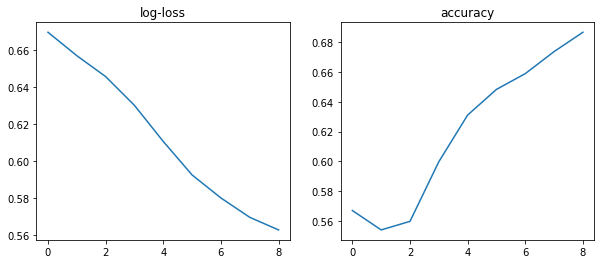

100%|██████████| 10/10 [00:22<00:00,  2.28s/it]


In [29]:
losses = []
accuracies = []
roc_aucs = []


for epoch in tqdm(range(10)):
    loss_float = 0
    accuracy_float = 0
    
    losses_epoch = []
    accuracies_epoch = []
    roc_aucs_epoch = []
    for X_cluster_graph in X_clusters_graph_train:
        predictions, (loss, accuracy, summary) = run_train(X_cluster_graph=X_cluster_graph,
                                   X_predictions=X_predictions,
                                   optimizer=optimizer, sess=sess, 
                                   ndim_features_nodes=ndim_features_nodes, 
                                   ndim_features_edges=ndim_features_edges, 
                                   placeholders=placeholders,
                                   metrics=[loss_tf, accuracy_tf, merged_summary])
        losses_epoch.append(loss)
        accuracies_epoch.append(accuracy)
    
    losses.append(np.mean(losses_epoch))
    accuracies.append(np.mean(accuracies_epoch))
    train_writer.add_summary(summary, epoch)

    if epoch % 2 == 0:
        clear_output()
        
        plt.figure(figsize=(10,4))
        ax = plt.subplot(121)
        plt.title('log-loss')
        plt.plot(losses)

        ax = plt.subplot(122)
        plt.title('accuracy')
        plt.plot(accuracies)
        plt.show()  

In [30]:
run_metadata = tf.RunMetadata()
train_writer.add_run_metadata(run_metadata, 'epoch_%d' % epoch)
train_writer.add_graph(tf.get_default_graph())

### Eval

In [51]:
losses_test = []
accuracies_test = []
roc_aucs_test = []
predictions_total = [] 
y_total =[]

for X_cluster_graph in X_clusters_graph_eval:
    predictions, (loss, accuracy) = run_test(X_cluster_graph=X_cluster_graph, 
                                              X_predictions=X_predictions,
                                              sess=sess, 
                                              ndim_features_nodes=ndim_features_nodes, 
                                              ndim_features_edges=ndim_features_edges, 
                                              placeholders=placeholders,
                                              metrics=[loss_tf, accuracy_tf])
    X_cluster_graph['predictions'] = predictions
    predictions_total.append(predictions)
    y_total.append(X_cluster_graph['Y_cluster_labels'])
    losses_test.append(loss)
    accuracies_test.append(accuracy)

In [52]:
predictions_total = np.concatenate(predictions_total)
y_total = np.concatenate(y_total)

In [53]:
y_total[0:10][:]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [54]:
from sklearn import metrics
accuracy = metrics.accuracy_score(np.argmax(y_total, axis=1), np.argmax(predictions_total, axis=1))
roc_auc = metrics.roc_auc_score(y_total, predictions_total)

In [55]:
accuracy

0.7139323480304248

In [56]:
roc_auc

0.7867158477062712

In [72]:
import zipfile

## Test

In [57]:
X_test, Y_test, M_test, N_test = hdf5_to_numpy(file=test_file, n=10, num_classes=num_classes, test=True)

  0%|          | 0/10 [00:00<?, ?it/s]

4000


100%|██████████| 10/10 [00:02<00:00,  4.19it/s]


In [58]:
shift = 0 if num_classes==4 else 1

In [59]:
import tables
expectedrows = len(X_test)
FILTERS = tables.Filters(complevel=5, complib='zlib', shuffle=True, bitshuffle=False, fletcher32=False, least_significant_digit=None)
f_submission = tables.open_file(submission_file, 'w', filters=FILTERS)
preds_array = f_submission.create_earray('/', 'pred', tables.UInt32Atom(), (0,192,192,192), expectedrows=expectedrows)

for k in tqdm(range(expectedrows)):
    submission_answer = np.zeros((192, 192, 192))
    if len(X_test[k]) == 0:
        pass
    else: 
        X_cluster_graph, in_degree_max_local, out_degree_max_local = generate_graph_dataset(X=X_test[k], 
                                                                                            Y=Y_test[k], 
                                                                                            M=M_test[k],
                                                                                            n_neighbors=n_neighbors, 
                                                                                            in_degree_max=in_degree_max, 
                                                                                            out_degree_max=out_degree_max)

        predictions, (loss, accuracy) = run_test(X_cluster_graph=X_cluster_graph, 
                                                  X_predictions=X_predictions,
                                                  sess=sess, 
                                                  ndim_features_nodes=ndim_features_nodes, 
                                                  ndim_features_edges=ndim_features_edges, 
                                                  placeholders=placeholders,
                                                  metrics=[loss_tf, accuracy_tf])
        submission_answer[X_cluster_graph['M'][:, 0], X_cluster_graph['M'][:, 1], X_cluster_graph['M'][:, 2]] = np.argmax(predictions, axis=1) + shift
        X_cluster_graph['submission_answer'] = submission_answer
    
    preds_array.append(np.expand_dims(submission_answer, axis=0))
    del submission_answer
preds_array.close()
f_submission.close()

100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


In [79]:
from datetime import datetime
from IPython.display import FileLink

In [93]:
submission_file_zip = "submission-%s.zip" % (datetime.now().strftime("%Y-%m-%d-%H%M"))

In [94]:
with zipfile.ZipFile(submission_file_zip, 'w', compression=zipfile.ZIP_DEFLATED) as myzip:
    myzip.write(submission_file)

In [39]:
!ls -lt *zip

-rw-rw-r-- 1 test-student test-student 55421 Aug 10 02:06 submission-2018-08-10-0206.zip


In [96]:
FileLink(submission_file_zip)

/mnt/students-home/test-student/anaderi-s2/phase_1-2/baseline_mpnn/submission-2018-08-10-0206.zip

# Final tips & tricks

If you want to drive up your score try following things:

  * stack MOAR layer;
  * more epochs;
  * change Dense `state_updater` on LSTM/GRU `state_updater`(btw, you just need to uncomment a bit of code in the section `NNs` and in `tools.mpnn.build_network`);
  * data augmentation;
  * btw, you might have noticed that I use different `message_passers` but single `state_updater` for each step. This is called _weight tightening_ and used to deal with overfitting;
  
  You can apply the same technique to `message_passers` or, alternatively, unravel `state_updater`. It's all up to you!
  
  * do not discard domain knowledge. Even if it's not applicable to feature engeneering you still can use in graph construction / smart clustering / loss function choice / structure of MPNN.
  * this version of MPNN learns on one sample per iteration, using batches could impove quality;
  * play with learning rate / optimizer type;